In [1]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools

import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA


from src import dataset
from src import helpers

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
data = dataset.load_excel(excel_file)
data = dataset.load_all_regions(data)

In [3]:
df_italy = data["italy"] # Arrivals to Italy
df_greek_island = data["greek_island"] # Arrivals to Greek Island
df_mainland_greece = data["mainland_greece"] # Arrivals to Mainland greece
df_fyrom = data["fyrom"] # Arrivals to fYRoM
df_serbia = data["serbia"] # Arrivals to Serbia
df_croatia = data["croatia"] # Arrivals to Croatia
df_hungry = data["hungry"] # Arrivals to Hungry
df_slovenia = data["slovenia"] # Arrivals to Slovenia
df_austria = data["austria"] # Arrivals to Austria

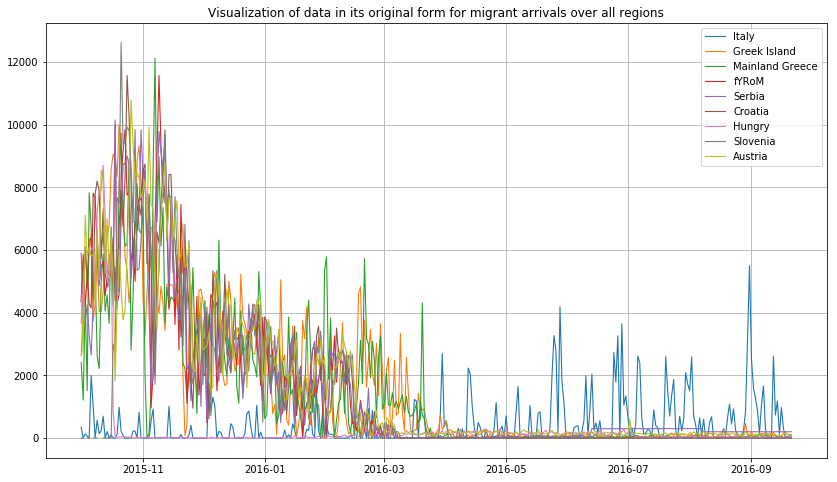

In [10]:
plt.figure(figsize=(14,8))
plt.plot(df_italy.index, df_italy.iloc[:, 0], label="Italy", linewidth=1.1)
plt.plot(df_greek_island.index, df_greek_island.iloc[:, 0], label="Greek Island", linewidth=1.1)
plt.plot(df_mainland_greece.index, df_mainland_greece.iloc[:, 0], label="Mainland Greece", linewidth=1.1)
plt.plot(df_fyrom.index, df_fyrom.iloc[:, 0], label="fYRoM", linewidth=1.1)
plt.plot(df_serbia.index, df_serbia.iloc[:, 0], label="Serbia", linewidth=1.1)
plt.plot(df_croatia.index, df_croatia.iloc[:, 0], label="Croatia", linewidth=1.1)
plt.plot(df_hungry.index, df_hungry.iloc[:, 0], label="Hungry", linewidth=1.1)
plt.plot(df_slovenia.index, df_slovenia.iloc[:, 0], label="Slovenia", linewidth=1.1)
plt.plot(df_austria.index, df_austria.iloc[:, 0], label="Austria", linewidth=1.1)
plt.legend(loc="best")
plt.title("Visualization of data in its original form for migrant arrivals over all regions")
plt.grid(True)
plt.show()

In [26]:
df = df_italy # Seriies to test
column_name = df.columns[0]
print("Region %s will be used for the analysis" % column_name)

Region Arrivals to Italy will be used for the analysis


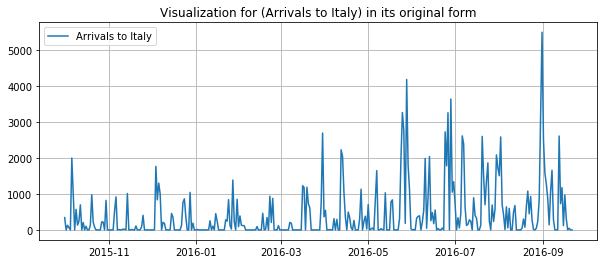

In [27]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [7]:
df.head()

,Arrivals to Italy
Date,
2015-10-01,343
2015-10-02,0
2015-10-03,128
2015-10-04,62
2015-10-05,0


In [8]:
df.tail()

,Arrivals to Italy
Date,
2016-09-17,317
2016-09-18,0
2016-09-19,47
2016-09-20,0
2016-09-21,0


In [33]:
#Stationarity test
def test_stationarity(timeseries, win_size=30):
    #Find rolling statistics
    rolmean = timeseries.rolling(window=win_size).mean()
    rolstd = timeseries.rolling(window=win_size).std()

    #Plot rolling statistics:
    plt.figure(figsize=(6,4))
    orig = plt.plot(timeseries, linewidth=1.2,label='Original')
    mean = plt.plot(rolmean, linewidth=1.2, label='Rolling Mean')
    std = plt.plot(rolstd, linewidth=1.2, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for Stationarity (Window size %s days)' % win_size)
    plt.grid()
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[timeseries.columns[0]], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
def show_seasonality(series, freq=7):
    plt.figure(figsize=(10,4))
    decomposition = seasonal_decompose(series, freq=freq, model="additive")
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return(trend, seasonal, residual)
    

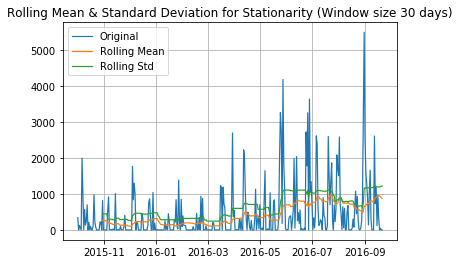

Results of Dickey-Fuller Test:
Test Statistic                -8.677227e+00
p-value                        4.382857e-14
#Lags Used                     1.000000e+00
Number of Observations Used    3.550000e+02
Critical Value (5%)           -2.869716e+00
Critical Value (1%)           -3.448906e+00
Critical Value (10%)          -2.571126e+00
dtype: float64


In [35]:
test_stationarity(df)

In [29]:
# Resample by weeks
w_df = df.resample("W").sum()
w_df = w_df.reset_index().rename(columns={'Date': 'ds', column_name: 'y'})
w_df = w_df.set_index("ds")
fill_method = "ffill"
w_df['y'] = w_df['y'].replace(to_replace=0, method=fill_method)
w_df.head()

,y
ds,
2015-10-04,533
2015-10-11,3954
2015-10-18,1007
2015-10-25,1399
2015-11-01,1265


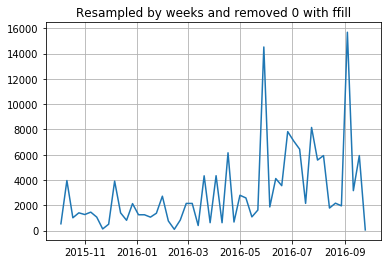

In [16]:
plt.plot(w_df)
plt.title("Resampled by weeks and removed 0 with %s" % fill_method)
plt.grid()
plt.show()

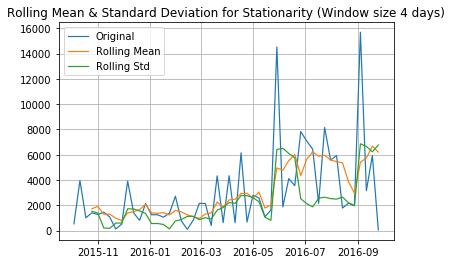

Results of Dickey-Fuller Test:
Test Statistic                 -0.414204
p-value                         0.907700
#Lags Used                      5.000000
Number of Observations Used    46.000000
Critical Value (5%)            -2.926785
Critical Value (1%)            -3.581258
Critical Value (10%)           -2.601541
dtype: float64


In [34]:
test_stationarity(w_df, win_size=4)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'nobs', 'observed', 'plot', 'resid', 'seasonal', 'trend']


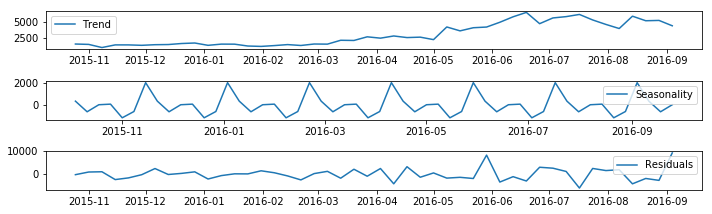

In [9]:
# Show seasonality in weekly resampled time series
(trend, seasonality, resid) = show_seasonality(w_df)

In [36]:
# Transformation to log on original data
l_df = copy.deepcopy(df)
l_df[l_df.columns[0]] = l_df[l_df.columns[0]].replace(to_replace=0, method=fill_method)
l_df[l_df.columns[0]] = np.log(list(l_df[l_df.columns[0]].values))
l_df.head()

,Arrivals to Italy
Date,
2015-10-01,5.837730
2015-10-02,5.837730
2015-10-03,4.852030
2015-10-04,4.127134
2015-10-05,4.127134


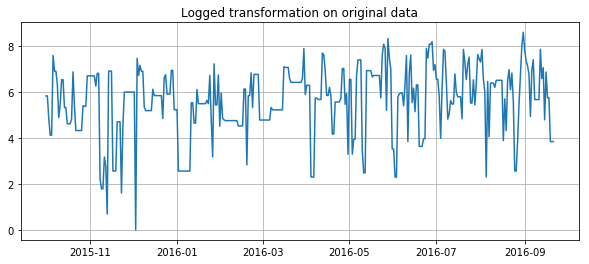

In [37]:
plt.figure(figsize=(10,4))
plt.plot(l_df)
plt.title("Logged transformation on original data")
plt.grid()
plt.show()

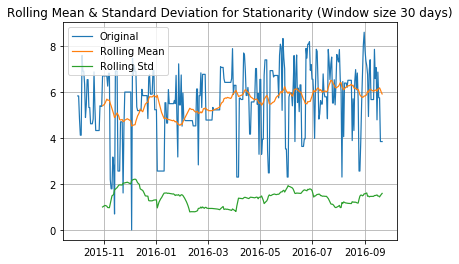

Results of Dickey-Fuller Test:
Test Statistic                -1.031730e+01
p-value                        3.073452e-18
#Lags Used                     0.000000e+00
Number of Observations Used    3.560000e+02
Critical Value (5%)           -2.869693e+00
Critical Value (1%)           -3.448853e+00
Critical Value (10%)          -2.571114e+00
dtype: float64


In [38]:
test_stationarity(l_df)

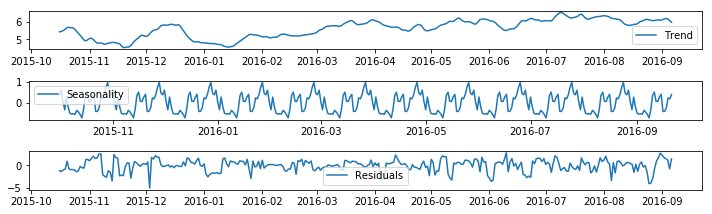

In [21]:
# Show seasonality in original logged time series
(trend, seasonality, resid) = show_seasonality(l_df, freq=30)

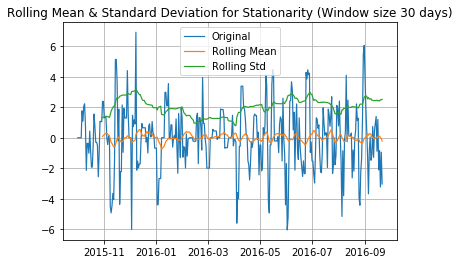

Results of Dickey-Fuller Test:
Test Statistic                -6.928373e+00
p-value                        1.100251e-09
#Lags Used                     1.700000e+01
Number of Observations Used    3.390000e+02
Critical Value (5%)           -2.870104e+00
Critical Value (1%)           -3.449788e+00
Critical Value (10%)          -2.571332e+00
dtype: float64


In [39]:
# Applying differencing with lag shift
l_df_diff = l_df - l_df.shift(5)
# l_df_diff.dropna(inplace=True)
l_df_diff.fillna(0, inplace=True)
test_stationarity(l_df_diff)

In [42]:
#test
l_df.head()

,Arrivals to Italy
Date,
2015-10-01,5.837730
2015-10-02,5.837730
2015-10-03,4.852030
2015-10-04,4.127134
2015-10-05,4.127134


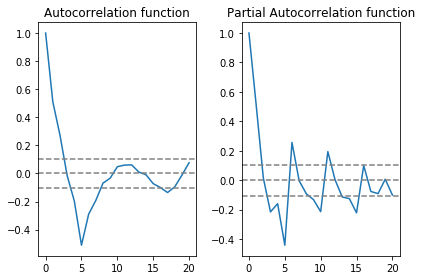

In [22]:
lag_acf = acf(l_df_diff, nlags=20)
lag_pacf = pacf(l_df_diff, nlags=20, method="ols")

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(l_df_diff)), linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(l_df_diff)), linestyle="--", color="gray")
plt.title("Autocorrelation function")

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(l_df_diff)), linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(l_df_diff)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation function")
plt.tight_layout()

In [27]:
import warnings
warnings.filterwarnings("ignore")
def grid_search(series, search_range=None):
    """Find the best p, d and q values for time series.
    
    :param series: Time series
    :type series: DataFrame
    :param search_range: Maximum value range for p, d and q
    :type search_range: list
    :returns: tuple containing lowest aic and p,d and q combination
    """
    lowest = 100000
    lowest_combination = None
    if search_range is None:
        search_range = range(0, 5)
    p=d=q=search_range
    pdq=list(itertools.product(p, d, q))
    for combination in pdq:
        try:
            model = ARIMA(series, order=combination)
            arima_fit = model.fit()
            prediction = arima_fit.fittedvalues
            if len(prediction) != len(series):
                print("Length problem")
                print(len(prediction), len(series))
                series.drop(series.tail(1).index,inplace=True)
            print(combination, helpers.measure_rmse(series, prediction), arima_fit.aic)
            
        except:
#             print(prediction.describe(), series.describe())
#             raise Exception
            continue
        
        if arima_fit.aic <= lowest:
                      lowest = arima_fit.aic
                      lowest_combination = combination
#         print(combination, arima_fit.aic)
    return (lowest_combination, lowest)

In [14]:
df_to_test = copy.deepcopy(l_df_diff)

In [441]:
#test
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)
# df_to_test = df_to_test.set_index('Date')
df_to_test = df - df.shift(5)
df_to_test = df_to_test.fillna(method="bfill")
# df_to_test = w_df.reset_index().rename(columns={'Date': 'ds', column_name: 'y'})
# w_df = w_df.set_index("ds")
df_to_test.head()

,Arrivals to Italy
Date,
2015-10-01,1658
2015-10-02,1658
2015-10-03,1658
2015-10-04,1658
2015-10-05,1658


In [31]:
orig_df = copy.deepcopy(df)
orig_df[column_name] = orig_df[column_name].replace(to_replace=0, method=fill_method)
orig_df = orig_df.fillna(method=fill_method)
grid_search_results = grid_search(orig_df)
# grid_search_results = grid_search(df_to_test)
best_combination = grid_search_results[0]
grid_search_results

(0, 0, 1) 651.6913249609479 5645.69605062277
(0, 0, 2) 630.9961665424396 5624.728457491724
(0, 0, 3) 626.8847539522345 5622.070179916338
(0, 0, 4) 617.7867660888434 5613.730317841543
Length problem
356 357
(0, 1, 1) 1124.8323193636777 5653.281448547173
Length problem
355 356
(0, 1, 2) 1328.9269641218816 5604.468304365059
Length problem
354 355
(0, 1, 3) 1262.8170649419158 5572.990975862427
Length problem
353 354
(0, 1, 4) 1251.2928719883885 5556.635676739337
Length problem
351 353
(1, 0, 0) 627.2940619939762 5539.961399202273
(1, 0, 1) 626.4506421505371 5541.018594094339
(1, 0, 2) 626.3219400952955 5542.8750804038245
(1, 0, 3) 625.9654937114298 5544.479435386589
(1, 0, 4) 621.1830767397005 5541.122368632794
Length problem
351 352
(1, 1, 0) 1041.479426471038 5591.923205764095
Length problem
350 351
(1, 1, 1) 1238.1147395479582 5505.648205776932
Length problem
349 350
(1, 1, 2) 1235.0356531777006 5490.420066147456
Length problem
348 349
(1, 1, 3) 1236.8509741267846 5477.367172383734
Leng

((4, 1, 1), 5170.7432275092015)

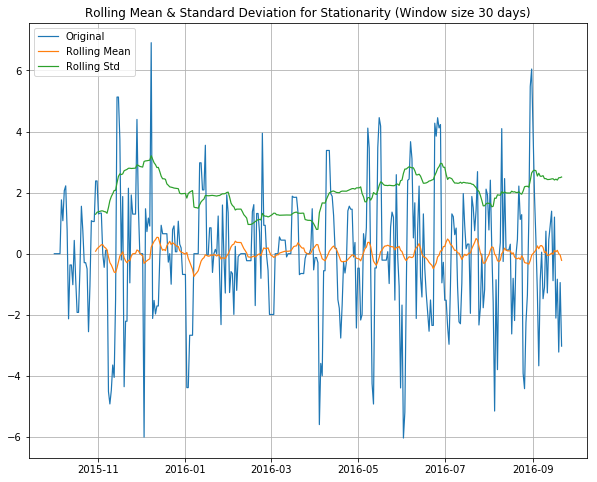

Results of Dickey-Fuller Test:
Test Statistic                -6.928373e+00
p-value                        1.100251e-09
#Lags Used                     1.700000e+01
Number of Observations Used    3.390000e+02
Critical Value (10%)          -2.571332e+00
Critical Value (1%)           -3.449788e+00
Critical Value (5%)           -2.870104e+00
dtype: float64


In [47]:
# test
# new = df - df.shift()
test_stationarity(df_to_test)

1
1231.131353388333


Date
2015-10-02       1.932201
2015-10-03       2.473221
2015-10-04      72.848117
2015-10-05      70.427636
2015-10-06      60.206668
2015-10-07    -693.037464
2015-10-08     -98.721179
2015-10-09    -170.911536
2015-10-10     -40.581589
2015-10-11     180.501726
2015-10-12     104.722473
2015-10-13     -77.559802
2015-10-14     -27.530819
2015-10-15     190.184955
2015-10-16     131.629246
2015-10-17     182.400430
2015-10-18     191.233036
2015-10-19     184.047003
2015-10-20     169.977020
2015-10-21    -246.805855
2015-10-22     177.556980
2015-10-23     185.204072
2015-10-24     142.776087
2015-10-25     176.609577
2015-10-26     177.722298
2015-10-27     172.243713
2015-10-28      94.229870
2015-10-29     102.848649
2015-10-30      97.773160
2015-10-31    -211.554059
                 ...     
2016-08-23     281.507010
2016-08-24     -39.360905
2016-08-25     322.933731
2016-08-26     446.989450
2016-08-27     420.687360
2016-08-28     438.098593
2016-08-29     350.591225
2016-08

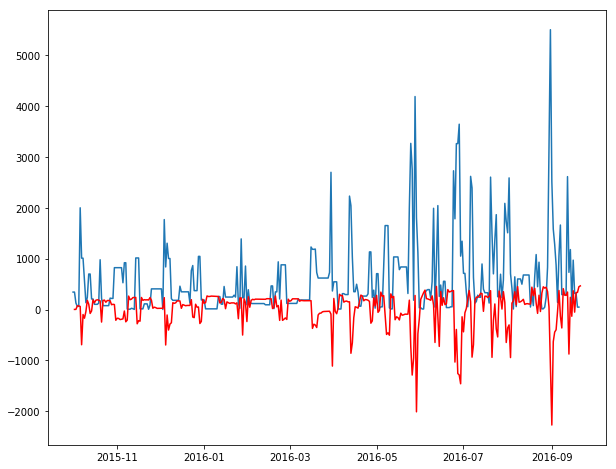

In [39]:
# test
orig_df = copy.deepcopy(df)
orig_df[column_name] = orig_df[column_name].replace(to_replace=0, method=fill_method)
orig_df = orig_df.fillna(method=fill_method)
model = ARIMA(orig_df, order=best_combination)
results_ARIMA = model.fit()
predictions = results_ARIMA.fittedvalues
difference = len(orig_df) - len(predictions)
if difference > 0:
    print(difference)
    orig_df.drop(orig_df.tail(difference).index,inplace=True)
    
error = helpers.measure_rmse(orig_df, predictions)
print(error)
plt.figure(figsize=(10,8))
plt.plot(orig_df)
plt.plot(predictions, color="red")
predictions
# plt.title("RSS: %.4f" % sum((predictions-df_to_test[df_to_test.columns[0]])**2))

Text(0.5, 1.0, 'RSS: 646.7592')

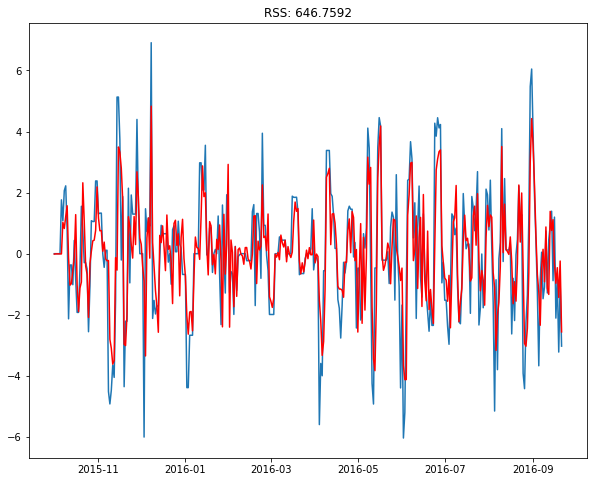

In [48]:
model = ARIMA(df_to_test, order=best_combination)
results_ARIMA = model.fit()

plt.figure(figsize=(10,8))
plt.plot(df_to_test)
plt.plot(results_ARIMA.fittedvalues, color="red")
plt.title("RSS: %.4f" % sum((results_ARIMA.fittedvalues-df_to_test[df_to_test.columns[0]])**2))

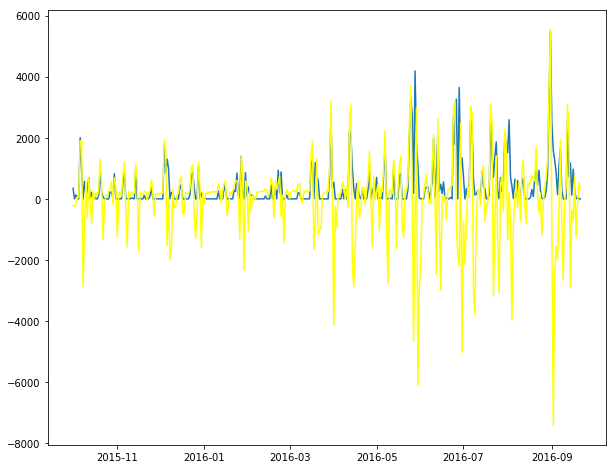

In [440]:
plt.figure(figsize=(10,8))
plt.plot(df)
prediction = pd.Series(results_ARIMA.fittedvalues, index=df_to_test.index)
orig = pd.Series(df_to_test[column_name].iloc[:], index=df_to_test.index)
# plt.plot(prediction, color="yellow")
# plt.show()
result = orig.add(prediction)
plt.plot(result, color="yellow")


In [70]:
def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

AttributeError: 'numpy.ndarray' object has no attribute 'annotate'

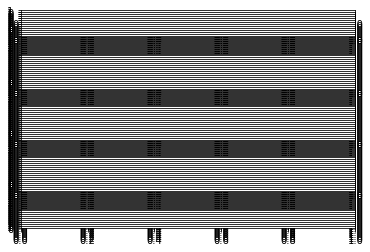

In [74]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True, index=df_to_test.index)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(l_df[column_name].ix[0], index=l_df.index)
# predictions_ARIMA_log.head()
# # predictions_ARIMA_log = df.add(results_ARIMA.fittedvalues)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff, fill_value=0)
predictions_ARIMA = np.exp(pd.DataFrame(predictions_ARIMA_log))

fig, ax = plt.subplots(111)
# fig, ax = plt.figure(figsize=(10,8))
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
plot.plot(df)
plot.plot(predictions_ARIMA)
type(pd.DataFrame(predictions_ARIMA))
# l_df_diff.head()
fig.canvas.mpl_connect("motion_notify_event", hover)
plt.show()

In [323]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, index=l_df.index)
predictions_ARIMA_diff.values

array([            nan,             nan,             nan,             nan,
                   nan, -5.22883188e-02,  4.57700444e-01,  6.66356917e-01,
        1.40419211e-01,  1.21445714e-01, -6.74403858e-01, -5.53484233e-01,
        4.48252724e-01, -3.64667015e-01,  8.00436466e-01,  3.48098820e-02,
       -3.00004590e-01,  3.36294570e-01, -3.84930398e-01,  3.20155935e-01,
        1.77137159e-01,  2.97969328e-01,  3.25982896e-01, -3.63727762e-02,
        2.25954374e-02,  5.13489558e-02, -7.43925872e-01, -1.14537075e-01,
       -2.21142085e-01, -1.66344022e-02,  6.63396406e-01,  1.10945371e-01,
        2.05331572e-01, -1.12905315e+00, -6.37623287e-01, -2.21815253e+00,
       -1.61268157e+00,  8.66456265e-01,  5.76293665e-01,  2.87486017e+00,
        1.54251353e+00,  1.48296844e-02, -4.35714240e-01, -5.76893016e-01,
       -5.52068452e-01, -1.41787884e-01, -3.09124249e-01,  1.40689207e-01,
       -3.25279332e-01,  6.92539874e-02, -6.62751734e-02,  3.06778348e-01,
       -3.01719973e-01, -

In [239]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.max())
predictions_ARIMA_diff_cumsum

2.4024136057124355


Date
2015-10-01         NaN
2015-10-02         NaN
2015-10-03   -0.020678
2015-10-04    0.095024
2015-10-05   -0.161316
2015-10-06   -0.059788
2015-10-07   -0.079117
2015-10-08   -1.239045
2015-10-09   -1.033050
2015-10-10   -1.981507
2015-10-11   -1.672632
2015-10-12   -1.437582
2015-10-13   -1.291083
2015-10-14   -1.995260
2015-10-15   -1.797844
2015-10-16   -2.211650
2015-10-17   -1.763508
2015-10-18   -2.387669
2015-10-19   -2.194162
2015-10-20   -2.551227
2015-10-21   -2.153929
2015-10-22   -2.422123
2015-10-23   -2.881490
2015-10-24   -3.151023
2015-10-25   -3.154244
2015-10-26   -3.092908
2015-10-27   -3.763865
2015-10-28   -3.250104
2015-10-29   -2.799665
2015-10-30   -2.922690
                ...   
2016-08-23   -5.456087
2016-08-24   -5.310544
2016-08-25   -4.752306
2016-08-26   -5.071688
2016-08-27   -5.171904
2016-08-28   -6.318192
2016-08-29   -5.798911
2016-08-30   -5.751982
2016-08-31   -6.038990
2016-09-01   -6.474112
2016-09-02   -6.676805
2016-09-03   -7.569608
2016-0

In [338]:
# predictions_ARIMA_log = pd.Series(l_df[l_df.columns[0]], index=l_df.index)
# print(predictions_ARIMA_log.max())
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum)
# predictions_ARIMA_log.head()
l_df[column_name].head()

Date
2015-10-01    7.786967
2015-10-02    7.102499
2015-10-03    8.407378
2015-10-04    7.321850
2015-10-05    8.966101
Name: Departures to mainland Greece, dtype: float64

16065.460901238195


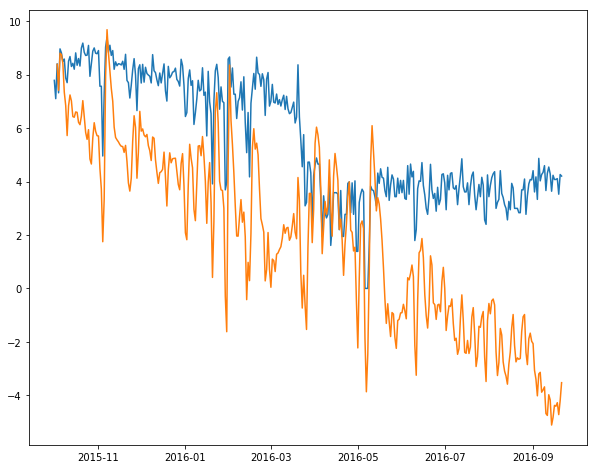

In [243]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA.max())
plt.figure(figsize=(10,8))
plt.plot(l_df)
plt.plot(predictions_ARIMA_log)

In [ ]:
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


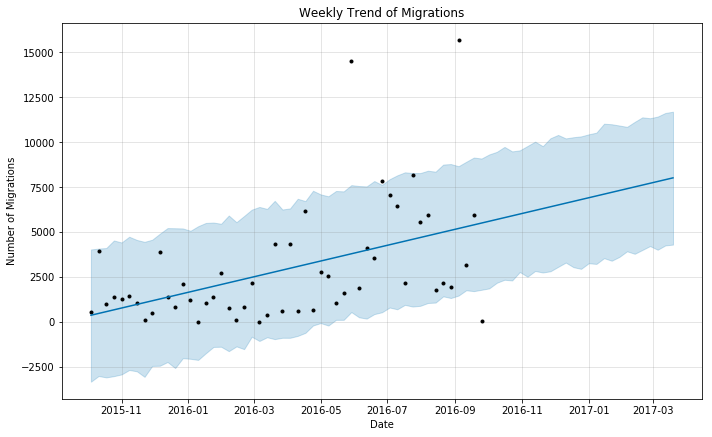

In [54]:
ph_model = fbprophet.Prophet(changepoint_prior_scale=0.14)
ph_model.fit(w_df)
ph_forecast = ph_model.make_future_dataframe(periods=25, freq='W')
ph_forecast = ph_model.predict(ph_forecast)

ph_model.plot(ph_forecast, xlabel = 'Date', ylabel = 'Number of Migrations')
plt.title('Weekly Trend of Migrations')
plt.show()

In [ ]:
# Commands to remember

df.sort_values("ColumnName").head() # Sort by column name
df.loc["2016-03-06"] # Find a value by certain index date
df.groupby(df.iloc[:, 0]).count().head() # Count all vaues in certain series
df.isnull().sum() # Sum of nulls